Import needed modules

In [1]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

modules loaded


# Create needed functions

Function to create dataframe

In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # valid and test dataframe
    files, classes = define_paths(tr_dir)
    dummy_df = define_df(files, classes)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123, stratify= strat)
    return train_df, valid_df, test_df

Function to generate images from dataframe

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

Function to show images

In [4]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

Callback Class

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

Function to plot history of training

In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


Function to create Confusion Matrix

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Model Structure

Show images sample

Found 38422 validated image filenames belonging to 11 classes.
Found 23053 validated image filenames belonging to 11 classes.
Found 15369 validated image filenames belonging to 11 classes.


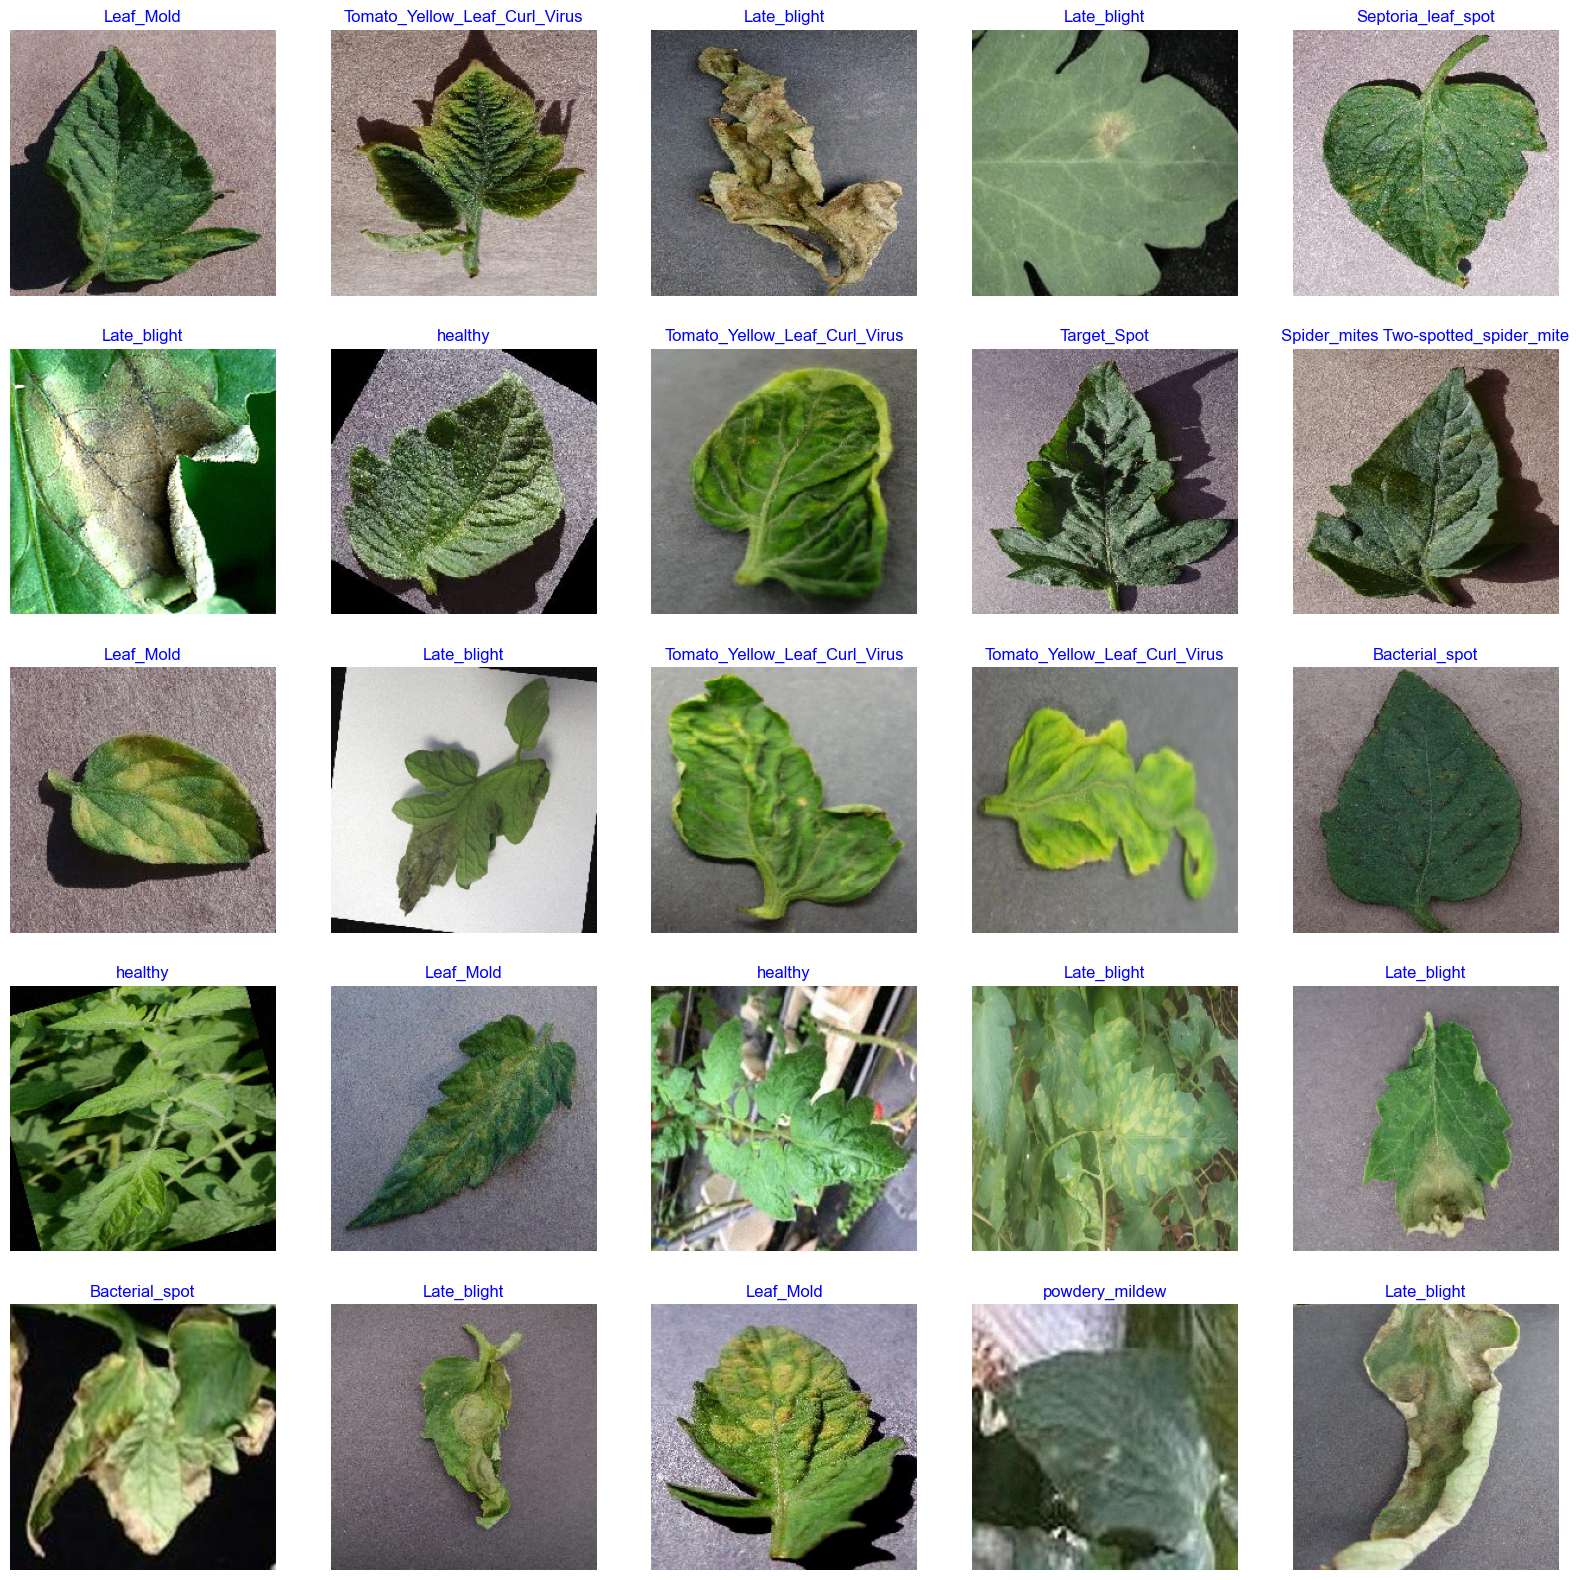

In [8]:
# Get Dataframes
train_dir = 'train'
valid_dir = 'valid'
train_df, valid_df, test_df = create_df(train_dir, valid_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

Create Pre-trained model

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                                 
Total params: 11,185,978
Trainable params: 11,095,603
Non-trainable params: 90,375
_______________________________________

Get custom callbacks parameters

In [10]:
batch_size = 40
epochs = 7
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
freeze = False
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs)]

Train model

In [11]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /7      3.556   83.973   0.87252  95.584   0.00100  0.00100  accuracy     0.00   7091.97 
 2 /7      0.592   94.232   0.33932  97.211   0.00100  0.00100  val_loss    61.11   13032.52
 3 /7      0.372   95.875   0.26810  97.406   0.00100  0.00100  val_loss    20.99   7114.55 
 4 /7      0.300   96.575   0.23049  97.623   0.00100  0.00100  val_loss    14.03   7246.45 
 5 /7      0.263   96.905   0.19524  98.026   0.00100  0.00100  val_loss    15.30   7598.81 
 6 /7      0.235   97.275   0.18657  98.057   0.00100  0.00100  val_loss     4.44   7606.11 
 7 /7      0.214   97.514   0.16524  98.586   0.00100  0.00100  val_loss    11.44   8487.66 
training elapsed time was 16.0 hours,  9.0 minutes, 38.76 seconds)


Plot training history

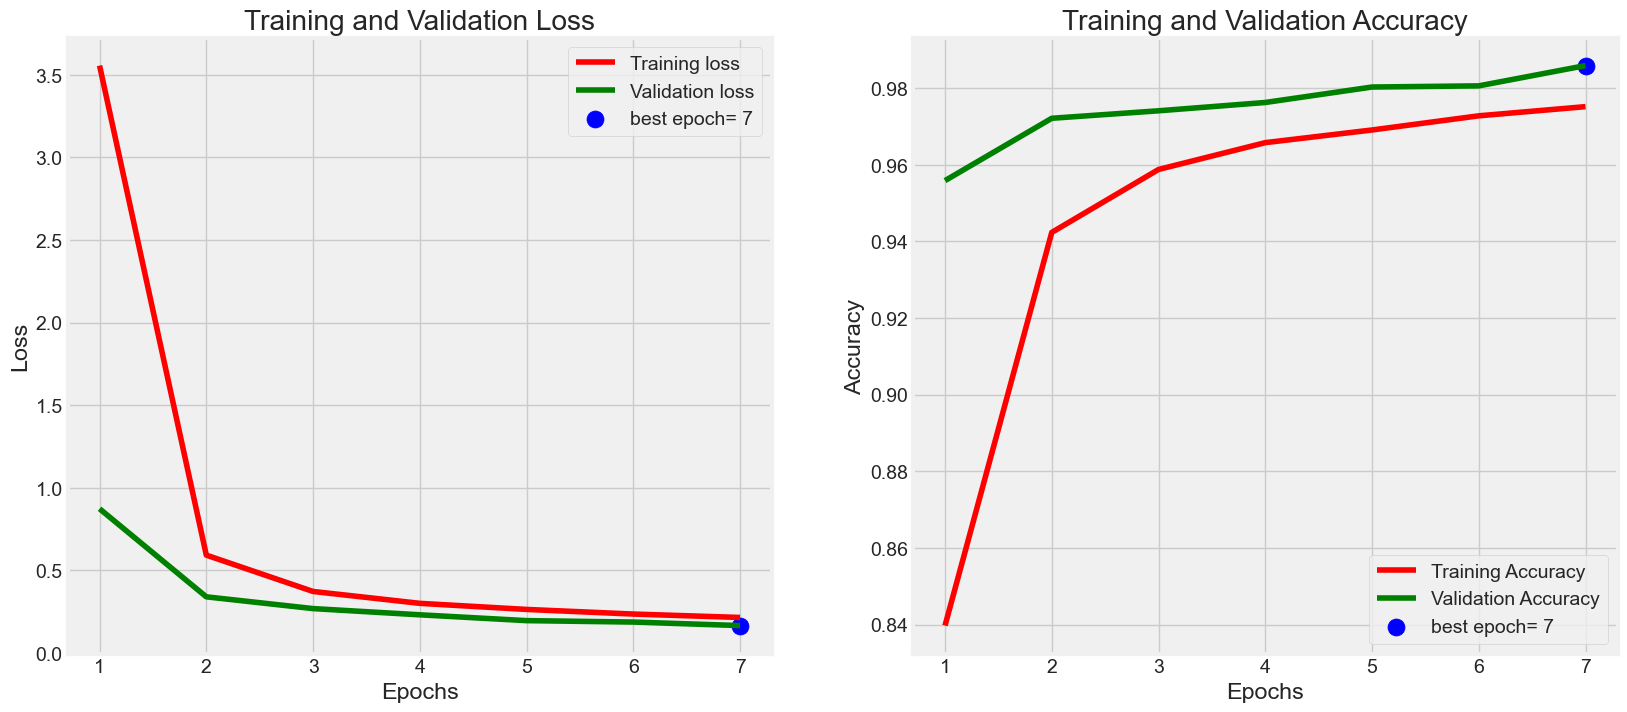

In [12]:
plot_training(history)

Evaluate model

In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

327/327 [==============================] - 557s 2s/step - loss: 0.1642 - accuracy: 0.9871
Train Loss:  0.16341665387153625
Train Accuracy:  0.9857033491134644
--------------------
Validation Loss:  0.1667720377445221
Validation Accuracy:  0.9850917458534241
--------------------
Test Loss:  0.1641703099012375
Test Accuracy:  0.9871169328689575


Make prediction 

In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

C:\Users\JOWAKO\AppData\Local\Temp\ipykernel_16628\2668681149.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[9 9 1 ... 8 4 2]


Confusion Matrix and Classification Report

Confusion Matrix, Without Normalization
[[1703    1    0    0    3    0    0    0    0    0    0]
 [   0 1481    4    0    1    0    0    0    0    0    0]
 [   3    1 1977  139    0    0    0    0    0    0    0]
 [   0    0   43 1279    0    0    0    0    0    0    0]
 [   1    0    0    0 1738    0    1    0    0    0    0]
 [   0    0    0    0    0 1046    1    0    0    0    0]
 [   0    0    0    0    0    0 1096    0    0    0    0]
 [   0    0    0    0    0    0    0 1218    0    0    0]
 [   0    0    0    0    0    0    0    0 1313    0    0]
 [   0    0    0    0    0    0    0    0    0 1718    0]
 [   0    0    0    0    0    0    0    0    0    0  602]]
                               precision    recall  f1-score   support

               Bacterial_spot       1.00      1.00      1.00      1707
                 Early_blight       1.00      1.00      1.00      1486
                  Late_blight       0.98      0.93      0.95      2120
                    Leaf_Mold       

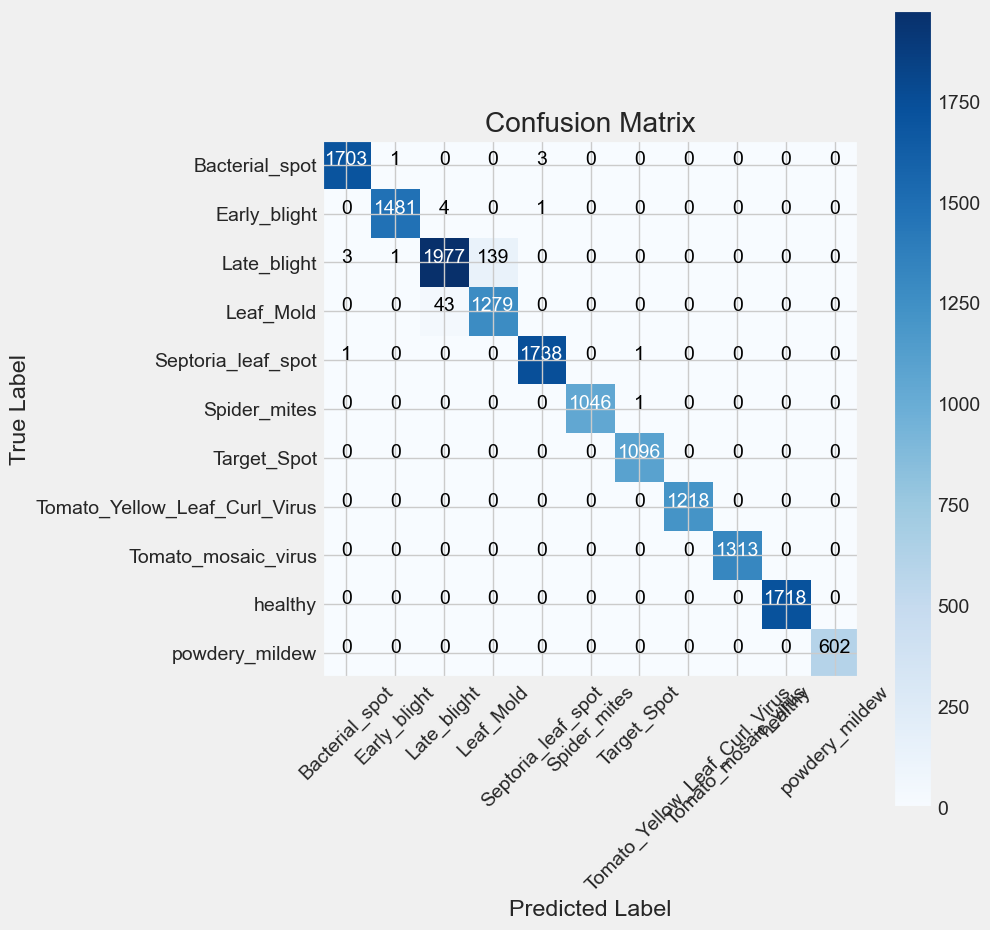

In [17]:
target_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

Save model

In [1]:
model_name = 'EffecientNetB3'
subject = 'Tomato-Disease-Detection'
acc = test_score[1] * 100
save_path = ''

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

NameError: name 'test_score' is not defined

Save class indices in CSV

In [19]:
class_dict = train_gen.class_indices
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
subject = ''
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as -class_dict.csv


In [28]:
import os
import json
import numpy as np
import tensorflow as tf

# 1. Crear directorio para el modelo si no existe
save_path = 'models'
os.makedirs(save_path, exist_ok=True)

# 2. Guardar el modelo en formato H5
try:
    model_filename = f'TomatoDisease_model_acc_{test_score[1]:.4f}.h5'
    model_path = os.path.join(save_path, model_filename)
    model.save(model_path, save_format='h5', include_optimizer=False)
    print(f'Modelo guardado exitosamente en: {model_path}')
except Exception as e:
    print(f"Error al guardar el modelo: {str(e)}")

# 3. Guardar el mapeo de clases por separado
try:
    class_indices = {k: int(v) for k, v in train_gen.class_indices.items()}
    classes_filename = 'classes.json'
    classes_path = os.path.join(save_path, classes_filename)
    
    with open(classes_path, 'w') as f:
        json.dump(class_indices, f, indent=4)
    print(f'Mapeo de clases guardado en: {classes_path}')
except Exception as e:
    print(f"Error al guardar el mapeo de clases: {str(e)}")

# 4. Verificar que se puede cargar (opcional)
try:
    loaded_model = tf.keras.models.load_model(model_path)
    print("✓ Verificación: El modelo se puede cargar correctamente")
    
    with open(classes_path, 'r') as f:
        loaded_classes = json.load(f)
    print("✓ Verificación: El mapeo de clases se puede cargar correctamente")
except Exception as e:
    print(f"Error en la verificación: {str(e)}")

Error al guardar el modelo: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Mapeo de clases guardado en: models\classes.json
Error en la verificación: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001900CC15B50>.


In [29]:
import os
import json
import tensorflow as tf

# Funciones auxiliares
def reset_weights(model):
    """Reset del estado de los tensores del modelo"""
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape))
        if hasattr(layer, 'bias_initializer'):
            layer.bias.assign(layer.bias_initializer(layer.bias.shape))

def save_model_safely(model, save_path):
    """Guarda el modelo de manera segura manejando los tensores"""
    try:
        # 1. Crear directorio si no existe
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # 2. Guardar pesos en formato checkpoint
        weights_path = save_path.replace('.h5', '_weights')
        model.save_weights(weights_path)
        print(f"Pesos guardados en: {weights_path}")
        
        # 3. Obtener y guardar la configuración del modelo
        model_config = model.get_config()
        config_path = save_path.replace('.h5', '_config.json')
        with open(config_path, 'w') as f:
            json.dump(str(model_config), f)
        print(f"Configuración guardada en: {config_path}")
        
        # 4. Intentar guardar el modelo completo
        try:
            model.save(save_path, include_optimizer=False)
            print(f"Modelo completo guardado en: {save_path}")
        except Exception as e:
            print(f"Advertencia: No se pudo guardar el modelo completo: {str(e)}")
            print("Sin embargo, los pesos y la configuración están guardados correctamente")
        
        return True
    except Exception as e:
        print(f"Error durante el guardado: {str(e)}")
        return False

# Guardar el modelo
try:
    # Preparar rutas
    base_dir = 'models'
    os.makedirs(base_dir, exist_ok=True)
    model_name = f'TomatoDisease_acc_{test_score[1]:.4f}'
    model_path = os.path.join(base_dir, f'{model_name}.h5')
    
    # Guardar el modelo
    success = save_model_safely(model, model_path)
    
    if success:
        print("\nGuardado básico completado.")
        
        # Guardar información adicional
        info = {
            'accuracy': float(test_score[1]),
            'classes': {k: int(v) for k, v in train_gen.class_indices.items()},
            'image_size': [224, 224],
            'channels': 3
        }
        
        info_path = os.path.join(base_dir, f'{model_name}_info.json')
        with open(info_path, 'w') as f:
            json.dump(info, f, indent=4)
        print(f"Información adicional guardada en: {info_path}")
        
        # Verificar que podemos cargar los pesos
        try:
            weights_path = model_path.replace('.h5', '_weights')
            temp_model = tf.keras.models.clone_model(model)
            temp_model.load_weights(weights_path)
            print("✓ Verificación: Los pesos se pueden cargar correctamente")
        except Exception as e:
            print(f"Error en verificación de pesos: {str(e)}")
            
except Exception as e:
    print(f"Error general: {str(e)}")

# Código para cargar el modelo posteriormente:
"""
def load_complete_model(base_path):
    # Cargar configuración
    with open(base_path + '_config.json', 'r') as f:
        config = json.load(f)
    
    # Recrear modelo
    model = tf.keras.models.model_from_config(eval(config))
    
    # Cargar pesos
    model.load_weights(base_path + '_weights')
    
    return model

# Ejemplo de uso:
# model = load_complete_model('models/TomatoDisease_acc_0.9871')
"""

Pesos guardados en: models\TomatoDisease_acc_0.9871_weights
Configuración guardada en: models\TomatoDisease_acc_0.9871_config.json
Advertencia: No se pudo guardar el modelo completo: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Sin embargo, los pesos y la configuración están guardados correctamente

Guardado básico completado.
Información adicional guardada en: models\TomatoDisease_acc_0.9871_info.json
✓ Verificación: Los pesos se pueden cargar correctamente


"\ndef load_complete_model(base_path):\n    # Cargar configuración\n    with open(base_path + '_config.json', 'r') as f:\n        config = json.load(f)\n    \n    # Recrear modelo\n    model = tf.keras.models.model_from_config(eval(config))\n    \n    # Cargar pesos\n    model.load_weights(base_path + '_weights')\n    \n    return model\n\n# Ejemplo de uso:\n# model = load_complete_model('models/TomatoDisease_acc_0.9871')\n"